In [1]:
from pycalphad import Database, variables as v
from localeq import composition_set, local_equilibrium
import numpy as np
from collections import defaultdict

In [2]:
dbf = Database('databases/mc_fe_v2.059.pycalphad.tdb')

/opt/conda/lib/python3.9/site-packages/pycalphad/io/tdb.py:974: UserWarning: The type definition character `%` was defined in the following phases: ['LIQUID', 'FCC_A1', 'BCC_A2', 'H_BCC', 'BCC_DISL', 'HCP_A3', 'ALPHA_MN', 'BETA_MN', 'BETA_RHOMBO_B', 'DIAMOND_A4', 'GRAPHITE', 'BCC_B2', 'CHI_A12', 'CO3MO', 'CO3V', 'COV3', 'CR3MN5', 'G_PHASE', 'LAVES_PHASE', 'MNNI', 'MNNI2', 'MNNI_T3', 'MU_PHASE', 'MU_PHASE_I', 'ETA', 'NITI2', 'PI_PHASE', 'R_PHASE', 'SIGMA', 'FE17Y2', 'NI5Y', 'PDFE_L12', 'PDMN_AF', 'PDMN_P', 'PDMN_B2', 'PD2MN', 'PD3MN', 'PD5MN3', 'PD6FE5MN2', 'CEMENTITE', 'CR2VC2', 'K_CARB', 'KSI_CARBIDE', 'M3C2', 'M6C', 'M7C3', 'M12C', 'M23C6', 'MOC_ETA', 'V3C2', 'WC', 'EPS_CARB', 'ETA_CARB', 'FE24C10', 'KSI_FE5C2', 'ALN', 'ALN_EQU', 'BN_HP4', 'CR3NI2SIN', 'FE4N', 'MN6N4', 'MN6N5', 'MNSIN2', 'SI3N4', 'ZET', 'CRB', 'CR2B', 'CR5B3', 'FEB', 'FENBB', 'FE3NB3B4', 'M2B', 'MNB2', 'MNB4', 'O_MN2B', 'MN3B4', 'MOB', 'MOB2', 'MO2M1B2', 'NBB', 'NB3B2', 'M5B6', 'TIB', 'TIB2', 'TI3B4', 'A_CHALC', 'ANI

# T0 Computation
The T0 (or T-zero) temperature is a thermodynamic quantity defined by an equality of the molar Gibbs energies of two different phases. T0 is relevant to the design of heat treatments for some alloys because, below the T0 temperature, so-called 'massive' transformation kinetics become active and may dominate the observed evolution of the microstructure. Massive transformations are diffusionless and can occur very rapidly, with no transformation barrier.

In [3]:
comps = ['FE', 'MN', 'VA']

state_variables = {v.N: 1, v.P: 1e5, v.T: 300}

fcc_composition_sets = [
                    composition_set(dbf, comps, 'FCC_A1',
                                    {**state_variables},
                                    phase_amt=1,
                                   ),  
                   ]
bcc_composition_sets = [
                    composition_set(dbf, comps, 'BCC_A2',
                                    {**state_variables},
                                    phase_amt=1,
                                   ),  
                   ]
x = []
y = defaultdict(lambda: [])
for temperature in np.arange(300., 2000.):
    state_variables[v.T] = temperature
    for compset in fcc_composition_sets:
        compset.dof[2] = temperature
        compset.update(compset.dof[2:], compset.NP, compset.dof[:2])
    for compset in bcc_composition_sets:
        compset.dof[2] = temperature
        compset.update(compset.dof[2:], compset.NP, compset.dof[:2])
    result_fcc, composition_sets = local_equilibrium(fcc_composition_sets, comps, {**state_variables, v.X('MN'): 0.1})
    result_bcc, composition_sets = local_equilibrium(bcc_composition_sets, comps, {**state_variables, v.X('MN'): 0.1})

    if not result_fcc.converged:
        print(temperature)
        raise ValueError('Convergence failure')
    if not result_bcc.converged:
        print(temperature)
        raise ValueError('Convergence failure')
    x.append(result_fcc.x[2])
    for compset in fcc_composition_sets:
        y[compset.phase_record.phase_name].append(float(compset.energy))
    for compset in bcc_composition_sets:
        y[compset.phase_record.phase_name].append(float(compset.energy))

(300.0, 2000.0)

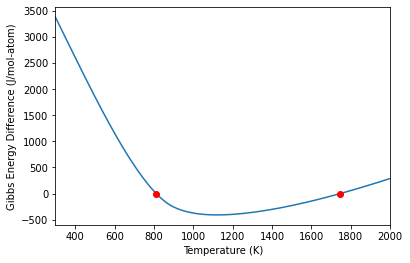

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycalphad.plot.utils import phase_legend
stable_phases = ['FCC_A1', 'BCC_A2']

energy_diff = np.array(y['FCC_A1']) - np.array(y['BCC_A2'])
sign_change_idx = np.where(np.diff(np.sign(energy_diff)) != 0)[0] + 1
sign_change_temps = np.array(x)[sign_change_idx]

plt.plot(x, energy_diff)
plt.scatter(sign_change_temps, np.zeros_like(sign_change_temps), c='r', zorder=3)
plt.ylabel('Gibbs Energy Difference (J/mol-atom)')
plt.xlabel('Temperature (K)')
plt.xlim(300, 2000)

In [5]:
print('FCC->BCC T0 Temperature: ', sign_change_temps[0], 'K', f'({sign_change_temps[0]-273.15} deg C)')

FCC->BCC T0 Temperature:  812.0 K (538.85 deg C)


# Precipitation Reaction
Note that the temperature corresponding to the onset of the corresponding precipitation reaction will always be greater than (or equal to) the T0 temperature. However, we may not always observe the precipitation reaction due to the slower, diffusion-controlled kinetics of the reaction. We can compute the onset of bcc stability by 'fixing' the bcc phase to be stable with zero amount.

In [7]:
comps = ['FE', 'MN', 'VA']

state_variables = {v.N: 1, v.P: 1e5}

composition_sets = [
                    composition_set(dbf, comps, 'BCC_A2',
                                    {**state_variables, v.T: 300},
                                    fixed=True, phase_amt=0,
                                   ),
                    composition_set(dbf, comps, 'FCC_A1',
                                    {**state_variables, v.T: 300},
                                    fixed=False, phase_amt=1,
                                   ),  
                   ]

result, composition_sets = local_equilibrium(composition_sets, comps, {**state_variables, v.X('MN'): 0.1})
print('Converged: ', result.converged)
print('Final Composition Sets: ', composition_sets)
print('FCC-BCC Transus Temperature', result.x[2], 'K', f'({int(result.x[2]-273.15)} deg C)')

Converged:  True
Final Composition Sets:  [CompositionSet(BCC_A2, [0.97103345 0.02896655], NP=0.0, GM=-38348.08591047841), CompositionSet(FCC_A1, [0.9 0.1], NP=0.9999999999999997, GM=-40125.765220405025)]
FCC-BCC Transus Temperature 925.2398175124108 K (652 deg C)
